<a href="https://colab.research.google.com/github/lvanderw/lvanderw_64061/blob/main/Polevault_Technique_Model_Lukas_van_der_Watt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/Polevault.zip /content


In [ ]:
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [ ]:
!unzip -qq Polevault.zip

In [ ]:
!rm -rf Polevault_Stages.zip

In [ ]:
!rm -rf DataPartition/

In [ ]:
!rm -rf convnet_from_scratch.keras1

In [ ]:
!rm -rf convnet_from_scratch_with_augmentation.keras

**Copying images to training, validation, and test directories**

In [ ]:
pip install split-folders


In [ ]:
import splitfolders

In [ ]:
# Split with a ratio.
splitfolders.ratio("Polevault", output="DataPartition",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [ ]:
import pathlib

In [ ]:
new_base_dir = pathlib.Path("DataPartition")
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "val",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 402 files belonging to 2 classes.
Found 85 files belonging to 2 classes.
Found 89 files belonging to 2 classes.


**Displaying the shapes of the data and labels yielded by the `Dataset`**

**Fitting the model using a `Dataset`**

**Implementing Early stopping to prevent overfitting of the model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#A patience of 5 epochs is set. This means that if the model validation loss contiously increase after 5 epochs it will stop model training


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
13/13 [==============================] - 39s 3s/step - loss: 0.0463 - accuracy: 0.9826 - val_loss: 1.6122 - val_accuracy: 0.7882
Epoch 2/15
13/13 [==============================] - 41s 3s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.7996 - val_accuracy: 0.7765
Epoch 3/15
13/13 [==============================] - 41s 3s/step - loss: 5.6510e-04 - accuracy: 1.0000 - val_loss: 2.1390 - val_accuracy: 0.7765
Epoch 4/15
13/13 [==============================] - 41s 3s/step - loss: 2.3017e-04 - accuracy: 1.0000 - val_loss: 2.3805 - val_accuracy: 0.7765
Epoch 5/15
13/13 [==============================] - 42s 3s/step - loss: 9.6265e-05 - accuracy: 1.0000 - val_loss: 2.5741 - val_accuracy: 0.7765
Epoch 6/15
13/13 [==============================] - 39s 3s/step - loss: 5.3662e-05 - accuracy: 1.0000 - val_loss: 2.7868 - val_accuracy: 0.7765
Epoch 7/15
13/13 [==============================] - 38s 3s/step - loss: 2.8357e-05 - accuracy: 1.0000 - val_loss: 2.9398 - val_accuracy: 0.7529


**Displaying curves of loss and accuracy during training**

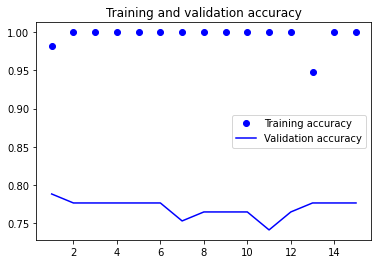

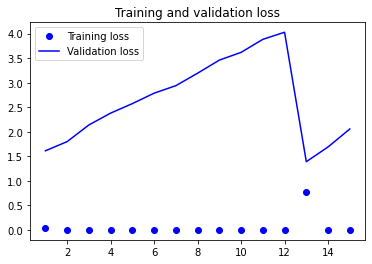

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 7s 1s/step - loss: 1.0638 - accuracy: 0.7303
Test accuracy: 0.730


#  **Using a Pretrained model VGG-16 with imagenet** 

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
train_path="DataPartition/train"
test_path="DataPartition/test"
val_path="DataPartition/val"

In [ ]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)
x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 402 images belonging to 2 classes.
Found 89 images belonging to 2 classes.
Found 85 images belonging to 2 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'Bad': 0, 'Good': 1}

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((402,), (89,), (85,))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
     input_shape=(224, 224,3))

In [ ]:
for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(conv_base.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=30,
  callbacks=[early_stop],
  batch_size=32)

Epoch 1/30
13/13 [==============================] - 247s 19s/step - loss: 0.8379 - accuracy: 0.6020 - val_loss: 0.5371 - val_accuracy: 0.7059
Epoch 2/30
13/13 [==============================] - 246s 19s/step - loss: 0.2742 - accuracy: 0.8731 - val_loss: 0.5191 - val_accuracy: 0.7176
Epoch 3/30
13/13 [==============================] - 247s 19s/step - loss: 0.1508 - accuracy: 0.9677 - val_loss: 0.4752 - val_accuracy: 0.7529
Epoch 4/30
13/13 [==============================] - 245s 19s/step - loss: 0.0938 - accuracy: 0.9975 - val_loss: 0.4599 - val_accuracy: 0.7647
Epoch 5/30
13/13 [==============================] - 245s 19s/step - loss: 0.0690 - accuracy: 1.0000 - val_loss: 0.4760 - val_accuracy: 0.7529
Epoch 6/30
13/13 [==============================] - 246s 19s/step - loss: 0.0514 - accuracy: 1.0000 - val_loss: 0.4899 - val_accuracy: 0.7647
Epoch 7/30
13/13 [==============================] - 245s 19s/step - loss: 0.0453 - accuracy: 0.9975 - val_loss: 0.5103 - val_accuracy: 0.7529
Epoch 

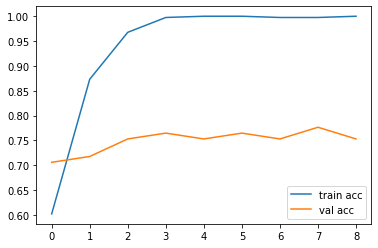

In [ ]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

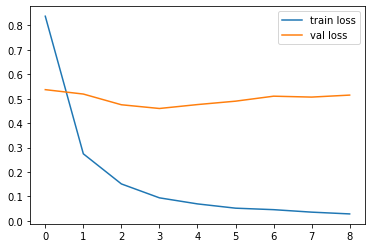

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [ ]:
model.evaluate(test_x,test_y,batch_size=32)

3/3 [==============================] - 45s 14s/step - loss: 0.4527 - accuracy: 0.7978


[0.4527008533477783, 0.7977527976036072]

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [ ]:
y_pred

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1])

In [ ]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,test_y))


              precision    recall  f1-score   support

           0       0.64      0.78      0.70        27
           1       0.89      0.81      0.85        62

    accuracy                           0.80        89
   macro avg       0.76      0.79      0.77        89
weighted avg       0.82      0.80      0.80        89



In [ ]:
#get confusion matrix
print(confusion_matrix(y_pred,test_y))

[[21  6]
 [12 50]]


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.4),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

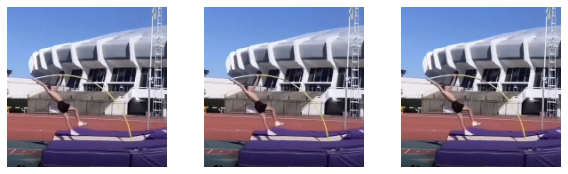

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(3):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 41s 3s/step - loss: 0.5649 - accuracy: 0.6667 - val_loss: 0.5984 - val_accuracy: 0.6824
Epoch 2/50
13/13 [==============================] - 40s 3s/step - loss: 0.5702 - accuracy: 0.6642 - val_loss: 0.6609 - val_accuracy: 0.6588
Epoch 3/50
13/13 [==============================] - 40s 3s/step - loss: 0.5644 - accuracy: 0.7090 - val_loss: 0.8937 - val_accuracy: 0.5647
Epoch 4/50
13/13 [==============================] - 40s 3s/step - loss: 0.6847 - accuracy: 0.6667 - val_loss: 0.6545 - val_accuracy: 0.5647
Epoch 5/50
13/13 [==============================] - 40s 3s/step - loss: 0.5479 - accuracy: 0.6816 - val_loss: 0.6740 - val_accuracy: 0.6941
Epoch 6/50
13/13 [==============================] - 40s 3s/step - loss: 0.5652 - accuracy: 0.6816 - val_loss: 0.6956 - val_accuracy: 0.6588
Epoch 7/50
13/13 [==============================] - 40s 3s/step - loss: 0.5557 - accuracy: 0.6716 - val_loss: 0.6394 - val_accuracy: 0.6000
Epoch 8/50
13/13 [==

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:3f}")

3/3 [==============================] - 9s 1s/step - loss: 0.4745 - accuracy: 0.7191
Test accuracy: 0.719101


**Evaluating the model on the test set**